# QFin Trading Platform Tutorial

In [1]:
from qfinuwa import Indicators
import pandas as pd

In [15]:

class CustomIndicators(Indicators):
        
    @Indicators.SingleIndicator
    def theo_etf(self, stocks):
        weights = {
            'AAPL': 74235724,
            'MSFT': 33656109,
            'NVDA': 11813404,
            'V': 7278487,
            'MA': 4106032,
            'AVGO': 1923552,
            'CRM': 4730962,
            'TXN': 4355505,
        }

        n_shares = sum(weights.values())
        tot = n_shares = 19697965 + 3013530
        factor = tot/n_shares

        midprices = [(w/n_shares)*stocks[s]['close'] for s,w in weights.items()]

        summation = sum(midprices)

        return factor*summation



In [9]:
ci = CustomIndicators()

data = [
    'AAPL',
    'MSFT',
    'NVDA',
    'V',
    'MA',
    'AVGO',
    'CRM',
    'TXN',
]

stocks = {d: pd.read_csv('./data/' + d + '.csv') for d in data}

# test etf indicator


In [16]:
singleindicator_output = ci.theo_etf(stocks)

In [11]:
true_etf = pd.read_csv('./data/VGT.csv')['close']

<AxesSubplot:>

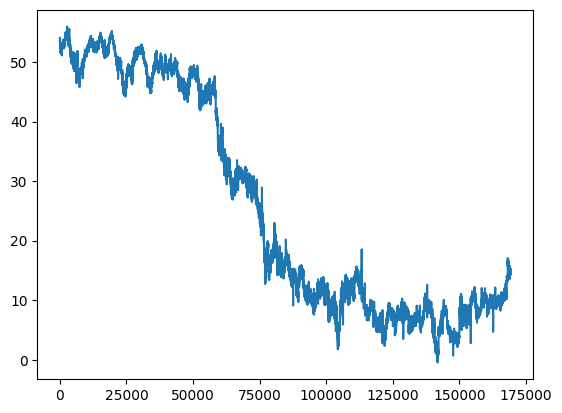

In [17]:
diff = true_etf - singleindicator_output
diff.plot()

<AxesSubplot:>

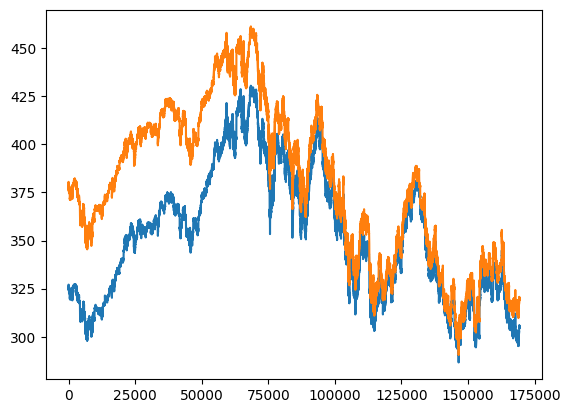

In [18]:
ax = singleindicator_output.plot(y='time')
true_etf.plot(ax=ax)

## Strategy Class

Similar to the ``Indicators`` class, we can implement a strategy by extending ``qfinuwa.Strategy``.

The null strategy would be implemented as follows:

In [11]:
from qfinuwa import Strategy

In [12]:

class MyStrategy(Strategy):
    
    def __init__(self):
        return
    
    def on_data(self, data, indicators, portfolio):
       return
    
    def on_finish(self):
        return

The strategy offers custom implementation of three functions.

- ``__init``: called on creation of the strategy
- ``on_data``: called every data tick 
- ``on_finish``: return an object to be appended to the results

### ``__init__``

You can create variables here that can be accessed by ``on_data`` at runtime. 

Similar to each of your indicator functions, ``kwargs`` can be specified as hyperparamters (more on this later).

### ``on_data``

``on_data`` expects 3 additional arugments that will be populated at runtime.

- ``data``: the historic data up to this point
- ``indicators``: the historic value of your custom indicators
- ``portfolio``: an object that manages your position

### ``on_finish``

Should return an object that will be added to the results. An example use case is if you want to measure some statistic over time, and the backtester doesn't offer it, so you record it yourself during runtime and return it via this function.

### Example 1 - BollingerBand

In [13]:
class MyStrategy(Strategy):
    
    def __init__(self, quantity=5):
        self.quantity = quantity
        self.n_failed_orders = 0
    
    def on_data(self, prices, indicators, portfolio):

        # If current price is below lower Bollinger Band, enter a long position
        for stock in portfolio.stocks:

            if(prices['close'][stock][-1] < indicators['lower_bollinger'][stock][-1]):
                order_success = portfolio.order(stock, self.quantity)
                if not order_success:
                    self.n_failed_orders += 1
            
            # If current price is above upper Bollinger Band, enter a short position
            if(prices['close'][stock][-1] > indicators['upper_bollinger'][stock][-1]):
                order_success = portfolio.order(stock, -self.quantity)
                if not order_success:
                    self.n_failed_orders += 1

    def on_finish(self):
        # Added to results object - access using result.on_finish
        return self.n_failed_orders

## Example 2 - RandomStrategy

In [14]:
import random

class RandomStrategy(Strategy):
    
    def __init__(self, quantity=5):
        self.quantity = quantity
        self.n_failed_orders = 0
    
    def on_data(self, prices, indicators, portfolio):

        # this strategy doesn't use prices or indicators - see BollingerBand Example

        s = random.choice(portfolio.stocks)
        q = random.randint(-self.quantity, self.quantity)

        order_success = portfolio.order(s, quantity=q)
        if not order_success:
            self.n_failed_orders += 1

    def on_finish(self):
        # Added to results object - access using result.on_finish
        return self.n_failed_orders

## Portfolio Class

To execute a trade, use the following function on the ``portfolio`` argument.

```py
portfolio.order('AAPL', 100) # buy 100 APPL
portfolio.order('GOOG', -50) # sell 50 GOOG
```

``portfolio.order`` will return ``True`` if successful and ``False`` if not. If a trade will exceed your delta limit, it will fail.

Some useful variables:

```py
portfolio.delta: dict           # current delta
portfolio.delta_limits: dict    # delta limits (set by backtester)
portfolio.stocks: list          # available stocks
```

Note, the backtester will return your delta to 0 (including fees if applicable).

## The Backtester

In [15]:
from qfinuwa import Backtester

In [17]:
backtester = Backtester(MyStrategy, CustomIndicators, ['AAPL','MSFT','GOOGL','NVDA'], 
                        data_folder='./data', days='all', fee=0.01, delta_limits=100)

> Precompiling data: 100%|██████████| 169299/169299 [00:06<00:00, 27765.91it/s]


The backtester may take a few seconds to create itself, but once it is created you shouldn't do it again unless you want to change the data. It takes a long time to create itself because it is precompiling the data for iterating.

``delta_limits`` can be dictionary of specific delta limits for each stock, or an integer that will apply to all stocks.

### Changing Backtesting Parameters

In [18]:
backtester

Backtester:
- Strategy: MyStrategy
	- Params: {'quantity': 5}
- Indicators: CustomIndicators
	- Params: {'bollinger_bands': {'BOLLINGER_WIDTH': 2, 'WINDOW_SIZE': 100}, 'etf': {'a': 0.2, 'b': 0.2, 'c': 0.05, 'd': 0.05}}
	- SingleIndicators: ['etf']
	- MultiIndicators: ['lower_bollinger', 'upper_bollinger']
- Stocks: ['AAPL', 'GOOGL', 'MSFT', 'NVDA']
- Fee 0.01
- delta_limit: {'AAPL': 100, 'GOOGL': 100, 'MSFT': 100, 'NVDA': 100}
- Days: all

In [19]:
backtester.fee = 0.001
backtester.delta_limits = {'AAPL': 100, 'GOOGL': 100, 'MSFT': 200, 'NVDA': 200}
# backtester.delta_limits = 100
backtester.days = 30

backtester

Backtester:
- Strategy: MyStrategy
	- Params: {'quantity': 5}
- Indicators: CustomIndicators
	- Params: {'bollinger_bands': {'BOLLINGER_WIDTH': 2, 'WINDOW_SIZE': 100}, 'etf': {'a': 0.2, 'b': 0.2, 'c': 0.05, 'd': 0.05}}
	- SingleIndicators: ['etf']
	- MultiIndicators: ['lower_bollinger', 'upper_bollinger']
- Stocks: ['AAPL', 'GOOGL', 'MSFT', 'NVDA']
- Fee 0.001
- delta_limit: {'AAPL': 100, 'GOOGL': 100, 'MSFT': 200, 'NVDA': 200}
- Days: 30

## Changing Strategy Parameters

In [20]:
print('current params', backtester.strategy.params)
print('default params', backtester.strategy.defaults)

current params {'quantity': 5}
default params {'quantity': 5}


In [21]:
backtester.strategy.update_params({'quantity': 10})

In [22]:
backtester.strategy = MyStrategy # update strategy (if you make a change)
# backtester.strategy = RandomStrategy

## Changing Indicator Parameters

In [23]:
print('current params', backtester.indicators.params)
print('default params', backtester.indicators.defaults)

current params {'bollinger_bands': {'BOLLINGER_WIDTH': 2, 'WINDOW_SIZE': 100}, 'etf': {'a': 0.2, 'b': 0.2, 'c': 0.05, 'd': 0.05}}
default params {'bollinger_bands': {'BOLLINGER_WIDTH': 2, 'WINDOW_SIZE': 100}, 'etf': {'a': 0.2, 'b': 0.2, 'c': 0.05, 'd': 0.05}}


In [24]:
backtester.indicators.update_params({'etf': {'a': 0.0}, 'bollinger_bands': {'BOLLINGER_WIDTH': 1, 'WINDOW_SIZE': 50}})

In [25]:
backtester.indicators = CustomIndicators

## Running Backtests

To run a backtest, use ``Backtester.run``.

``run`` will pick ``cv`` random periods of ``backtester.days`` days and run your strategy on that window of data. If you want reproducibility, use ``seed`` to use the same random generation every time, else ommit it as a key word argument.

In [30]:
output = backtester.run(cv=2, seed=2023)

> Running backtest over 2 samples of 30 days: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


In [32]:

print(output)

print(output.roi)
print(output[1].roi)

# [run.roi for run in output]

# Example of obtaining custom runtime data (see Strategy.on_finish)
print('# failed orders:', [run.on_finish for run in output])

# Get parameters 
print(output.parameters)


{'strategy': {'quantity': 10}, 'indicator': {'bollinger_bands': {'BOLLINGER_WIDTH': 2, 'WINDOW_SIZE': 100}, 'etf': {'a': 0.2, 'b': 0.2, 'c': 0.05, 'd': 0.05}}}

Mean ROI:	45.662409469147406
STD ROI:	4484.424213093394

26/01/2022 -> 24/02/2022:	-4438.762
20/09/2022 -> 19/10/2022:	4530.087

AVERAGED RESULTS FOR 2 RUNS:
|               |     AAPL |    GOOGL |     MSFT |    NVDA |        Net |
|---------------|----------|----------|----------|---------|------------|
| n_trades      |    650.5 |      583 |    849.5 |   883.5 |     2966.5 |
| n_buys        |    324.5 |    291.5 |      426 |     435 |       1477 |
| n_sells       |      326 |    291.5 |    423.5 |   448.5 |     1489.5 |
| gross_pnl     |  1234.45 |  881.662 |  141.699 | 2891.09 |     5148.9 |
| fees_paid     |  1017.62 |  1528.75 |  979.307 | 1577.56 |    5103.23 |
| net_pnl       |  216.825 | -647.086 | -837.608 | 1313.53 |    45.6624 |
| pnl_per_trade | 0.325974 | -1.16572 | -1.23093 |  1.3487 | -0.0933736 |
(45.6624094691

Or you can specify which dates to start (the end date will be specified by ``backtester.days``).

Note, not all days will contain data - the market may be closed.

In [ ]:

print(backtester.date_range, backtester.days)
output = backtester.run(cv=5, start_dates=['2021-06-07', '2021-04-19', '2022-01-01'])

print(output)

(Timestamp('2021-04-19 09:31:00'), Timestamp('2023-01-06 15:59:00')) 30


> Running backtest over 3 samples of 30 days: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


{'strategy': {'quantity': 10}, 'indicator': {'bollinger_bands': {'BOLLINGER_WIDTH': 2, 'WINDOW_SIZE': 100}, 'etf': {'a': 0.2, 'b': 0.2, 'c': 0.05, 'd': 0.05}}}

Mean ROI:	-5545.1129596610035
STD ROI:	2393.721229841482

06/07/2021 -> 04/08/2021:	-4023.076
19/04/2021 -> 18/05/2021:	-3687.467
03/01/2022 -> 28/01/2022:	-8924.796

AVERAGED RESULTS FOR 3 RUNS:
|               |     AAPL |    GOOGL |     MSFT |     NVDA |      Net |
|---------------|----------|----------|----------|----------|----------|
| n_trades      |  581.667 |      578 |  843.333 |  768.667 |  2771.67 |
| n_buys        |  293.333 |      288 |  423.667 |  384.333 |  1389.33 |
| n_sells       |  288.333 |      290 |  419.667 |  384.333 |  1382.33 |
| gross_pnl     |  284.199 |  434.784 | -62.7265 | -1221.54 |  -565.28 |
| fees_paid     |  840.357 |   1590.2 |  1063.05 |  1486.22 |  4979.83 |
| net_pnl       | -556.158 | -1155.41 | -1125.78 | -2707.76 | -5545.11 |
| pnl_per_trade | -1.03811 | -1.76914 | -1.43114 |  -4.280

You can either use ``Backtester.strategy.update_params`` to update parameters, or just give them to ``run``.

In [33]:
S = {
    'quantity': 1
}

I = {
    'bollinger_bands': {
        'BOLLINGER_WIDTH': 1,
        'WINDOW_SIZE': 50
    },
    'etf': {
        'a': 0.0
    }
}


output = backtester.run(strategy_params = S, indicator_params = I, cv=1)

> Running backtest over 1 sample of 30 days: 100%|██████████| 7624/7624 [00:00<00:00, 7871.87it/s]


## Hyper-Parameter Sweep

To run a basic grid-search over all your hyperparameters, use ``Backtester.run_grid_search``.

In [34]:
output = backtester.run_grid_search(
    strategy_params={'quantity': [1, 10]},
    indicator_params={'bollinger_bands': {
                            'BOLLINGER_WIDTH': [1, 2], 
                            }, 
                        'etf': {'a': [0.0, 0.5]}},
    cv=2)

> Backtesting the across the following ranges:
Agorithm Parameters {'quantity': [1, 10]}
Indicator Parameters {'bollinger_bands': {'BOLLINGER_WIDTH': [1, 2], 'WINDOW_SIZE': 100}, 'etf': {'a': [0.0, 0.5], 'b': 0.2, 'c': 0.05, 'd': 0.05}}


Running paramter sweep (cv=2): 100%|██████████| 8/8 [00:12<00:00,  1.61s/it]


In [35]:
print(output.parameters)
output

({'quantity': [1, 10]}, {'bollinger_bands': {'BOLLINGER_WIDTH': [1, 2], 'WINDOW_SIZE': 100}, 'etf': {'a': [0.0, 0.5], 'b': 0.2, 'c': 0.05, 'd': 0.05}})


Best parameter results:

{'strategy': {'quantity': 1}, 'indicator': {'bollinger_bands': {'BOLLINGER_WIDTH': 2, 'WINDOW_SIZE': 100}, 'etf': {'a': 0.0, 'b': 0.2, 'c': 0.05, 'd': 0.05}}}

Mean ROI:	220.22170230275316
STD ROI:	694.7741542614506

27/09/2021 -> 26/10/2021:	-474.552
16/12/2021 -> 14/01/2022:	914.996

AVERAGED RESULTS FOR 2 RUNS:
|               |      AAPL |       GOOGL |     MSFT |        NVDA |       Net |
|---------------|-----------|-------------|----------|-------------|-----------|
| n_trades      |      1234 |      1143.5 |     1261 |      1207.5 |      4846 |
| n_buys        |       596 |       587.5 |    583.5 |       593.5 |    2360.5 |
| n_sells       |       638 |         556 |    677.5 |         614 |    2485.5 |
| gross_pnl     |  -27.8202 |     342.416 |  654.318 |     275.387 |    1244.3 |
| fees_paid     |   194.281 |     351.438 |  177.147 |     301.213 |   1024.08 |
| net_pnl       |  -222.101 |     -9.0217 |  477.171 |    -25.8265 |   220.222 |
| pnl_per_t

## Plotting

In [36]:
from qfinuwa import Plotting

In [37]:
output = backtester.run(cv=3)
Plotting.plot_result(output[0], stocks=['NVDA', 'MSFT'], show_transactions = True, show_portfolio=False)

> Running backtest over 3 samples of 30 days: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]
